# React Agent + Tools 示例

In [1]:
! pip install -U langgraph langchain-openai tavily-python langchain-community

  Obtaining dependency information for tavily-python from https://files.pythonhosted.org/packages/b3/04/13e657e010a1257c56a2e52a0032ce1abd993b75553ddf838b26d7abe75c/tavily_python-0.4.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


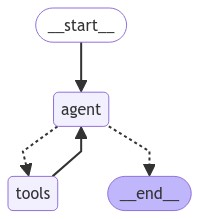

================================ Human Message =================================

汪峰最近一起上热搜是什么时候？
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_PCYQTZeyK68FXLLh7LchbPWU)
 Call ID: call_PCYQTZeyK68FXLLh7LchbPWU
  Args:
    query: 汪峰最近上热搜
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.sohu.com/a/729361156_121798215", "content": "\u5728\u4e92\u52a8\u73af\u8282\uff0c\u6709\u540c\u5b66\u63d0\u95ee\uff1a\"\u6bcf\u6b21\u60a8\u7684\u51fa\u73b0\u603b\u611f\u89c9\u5185\u5a31\u5f97\u51fa\u70b9\u4e8b\"\uff0c\u5e76\u4e3e\u4f8b\u4e86\u6c6a\u5cf0\u8fd1\u671f\u4e0a\u8fc7\u7684\u51e0\u6b21\u70ed\u641c\uff0c \u6bd4\u5982\"\u6c6a\u5cf0\u88ab\u66dd\u5149\u5728\u5bb6\u91cc\u5438\u5c18\"\u3001\"\u6c6a\u5cf0\u88ab\u66dd\u5149\u5728\u5bb6\u91cc\u6d17\u7897\"\u3001\"\u6c6a\u5cf0\u88ab\u66dd\u5149\u5728\u5bb6\u91cc\u6253\u626b\u536b\u751f\"\u

In [8]:
import os
from langchain_openai import ChatOpenAI
from typing import Literal
from langchain_core.tools import tool
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
# LangSmith 项目名称，默认 default
os.environ["LANGCHAIN_PROJECT"] = "default"
# Tavily API Key
os.environ["TAVILY_API_KEY"] = "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"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

tools = [TavilySearchResults(max_results=1)]
model_with_tools = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)
tool_node = ToolNode(tools)
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")
app = workflow.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

for chunk in app.stream(
    {"messages": [("human", "2024年深圳程序员平均薪酬")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()